# Detailed Simulation for the basics section

In [1]:
import numpy as np
from doubleml.datasets import make_plr_CCDDHNR2018

np.random.seed(1234)
n_rep = 1000
n_obs = 500
n_vars = 20
alpha = 0.5

data = list()

for i_rep in range(n_rep):
    (x, y, d) = make_plr_CCDDHNR2018(alpha=alpha, n_obs=n_obs, dim_x=n_vars, return_type='array')
    data.append((x, y, d))

In [2]:
import seaborn as sns
sns.set()

In [3]:
def non_orth_score(y, d, l_hat, m_hat, g_hat, smpls):
    u_hat = y - g_hat
    psi_a = -np.multiply(d, d)
    psi_b = np.multiply(d, u_hat)
    return psi_a, psi_b

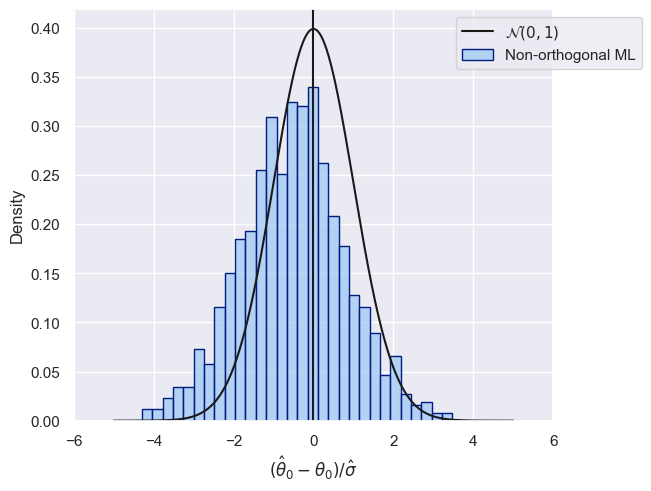

In [4]:
from doubleml import DoubleMLData
from doubleml import DoubleMLPLR


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import numpy as np
import warnings

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
face_colors = sns.color_palette('pastel')
edge_colors = sns.color_palette('dark')

warnings.filterwarnings("ignore")

np.random.seed(1111)

ml_l = RandomForestRegressor(n_estimators=132, max_features=12, max_depth=5, min_samples_leaf=1)
ml_m = RandomForestRegressor(n_estimators=378, max_features=20, max_depth=3, min_samples_leaf=6)
ml_g = clone(ml_l)

theta_nonorth = np.full(n_rep, np.nan)
se_nonorth = np.full(n_rep, np.nan)

for i_rep in range(n_rep):
    print(f'Replication {i_rep+1}/{n_rep}', end='\r')
    (x, y, d) = data[i_rep]
    
    # choose a random sample for training and estimation
    i_train, i_est = train_test_split(np.arange(n_obs), test_size=0.5, random_state=42)
    
    # fit the ML algorithms on the training sample
    ml_l.fit(x[i_train, :], y[i_train])
    ml_m.fit(x[i_train, :], d[i_train])

    psi_a = -np.multiply(d[i_train] - ml_m.predict(x[i_train, :]), d[i_train] - ml_m.predict(x[i_train, :]))
    psi_b = np.multiply(d[i_train] - ml_m.predict(x[i_train, :]), y[i_train] - ml_l.predict(x[i_train, :]))
    theta_initial = -np.nanmean(psi_b) / np.nanmean(psi_a)
    ml_g.fit(x[i_train, :], y[i_train] - theta_initial * d[i_train])

    # create out-of-sample predictions
    l_hat = ml_l.predict(x[i_est, :])
    m_hat = ml_m.predict(x[i_est, :])
    g_hat = ml_g.predict(x[i_est, :])

    external_predictions = {
        'd': {
            'ml_l': l_hat.reshape(-1, 1),
            'ml_m': m_hat.reshape(-1, 1),
            'ml_g': g_hat.reshape(-1, 1)
        }
    }

    obj_dml_data = DoubleMLData.from_arrays(x[i_est, :], y[i_est], d[i_est])
    obj_dml_plr_nonorth = DoubleMLPLR(obj_dml_data,
                                    ml_l, ml_m, ml_g,
                                    n_folds=2,
                                    score=non_orth_score)
    obj_dml_plr_nonorth.fit(external_predictions=external_predictions)
    theta_nonorth[i_rep] = obj_dml_plr_nonorth.coef[0]
    se_nonorth[i_rep] = obj_dml_plr_nonorth.se[0]

plt.figure(constrained_layout=True);
ax = sns.histplot((theta_nonorth - alpha)/se_nonorth,
                color=face_colors[0], edgecolor = edge_colors[0],
                stat='density', bins=30, label='Non-orthogonal ML');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');

In [5]:
print(repr(theta_nonorth).replace('\n      ', ''))
print(repr(se_nonorth).replace('\n      ', ''))

array([0.52841184, 0.53257557, 0.45776899, 0.4034401 , 0.49308693, 0.46463789, 0.55063783, 0.40742445, 0.45367791, 0.51786415, 0.40822494, 0.49702455, 0.52528277, 0.38661609, 0.50213674, 0.50178833, 0.53561741, 0.41565032, 0.3987447 , 0.46041457, 0.48050088, 0.41999129, 0.39651686, 0.42747658, 0.53006376, 0.38270744, 0.44626667, 0.48804163, 0.35279742, 0.50683999, 0.50569159, 0.43932707, 0.42835903, 0.37534938, 0.53875962, 0.47542356, 0.4867241 , 0.43045564, 0.47683269, 0.38616173, 0.48135896, 0.43197366, 0.53024388, 0.32050627, 0.51439563, 0.52240987, 0.54046475, 0.50142422, 0.45240075, 0.5917202 , 0.47153499, 0.40236401, 0.47655041, 0.51215273, 0.5188436 , 0.41996805, 0.46252855, 0.50985946, 0.43016444, 0.40835239, 0.47352812, 0.5545049 , 0.49824284, 0.47882132, 0.51631372, 0.35315349, 0.40218318, 0.51247644, 0.59196977, 0.52489753, 0.46485458, 0.44838539, 0.5276024 , 0.39472645, 0.40988155, 0.47038544, 0.56912904, 0.47714195, 0.42080583, 0.50365934, 0.41416075, 0.48534731, 0.4412234

In [6]:
import numpy as np
np.random.seed(2222)

theta_orth_nosplit = np.full(n_rep, np.nan)
se_orth_nosplit = np.full(n_rep, np.nan)

for i_rep in range(n_rep):
    print(f'Replication {i_rep+1}/{n_rep}', end='\r')
    (x, y, d) = data[i_rep]

    # fit the ML algorithms on the training sample
    ml_l.fit(x, y)
    ml_m.fit(x, d)

    psi_a = -np.multiply(d - ml_m.predict(x), d - ml_m.predict(x))
    psi_b = np.multiply(d - ml_m.predict(x), y - ml_l.predict(x))
    theta_initial = -np.nanmean(psi_b) / np.nanmean(psi_a)
    ml_g.fit(x, y - theta_initial * d)

    l_hat = ml_l.predict(x)
    m_hat = ml_m.predict(x)
    g_hat = ml_g.predict(x)

    external_predictions = {
        'd': {
            'ml_l': l_hat.reshape(-1, 1),
            'ml_m': m_hat.reshape(-1, 1),
            'ml_g': g_hat.reshape(-1, 1)
        }
    }

    obj_dml_data = DoubleMLData.from_arrays(x, y, d)
    
    obj_dml_plr_orth_nosplit = DoubleMLPLR(obj_dml_data,
                                        ml_l, ml_m, ml_g,
                                        score='IV-type')
    obj_dml_plr_orth_nosplit.fit(external_predictions=external_predictions)
    theta_orth_nosplit[i_rep] = obj_dml_plr_orth_nosplit.coef[0]
    se_orth_nosplit[i_rep] = obj_dml_plr_orth_nosplit.se[0]

plt.figure(constrained_layout=True);
ax = sns.histplot((theta_orth_nosplit - alpha)/se_orth_nosplit,
                color=face_colors[1], edgecolor = edge_colors[1],
                stat='density', bins=30, label='Double ML (no sample splitting)');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));    
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');

In [ ]:
print(repr(theta_orth_nosplit).replace('\n      ', ''))
print(repr(se_orth_nosplit).replace('\n      ', ''))

In [ ]:
import numpy as np
np.random.seed(3333)

theta_dml = np.full(n_rep, np.nan)
se_dml = np.full(n_rep, np.nan)

for i_rep in range(n_rep):
    print(f'Replication {i_rep+1}/{n_rep}', end='\r')
    (x, y, d) = data[i_rep]
    obj_dml_data = DoubleMLData.from_arrays(x, y, d)
    obj_dml_plr = DoubleMLPLR(obj_dml_data,
                            ml_l, ml_m, ml_g,
                            n_folds=2,
                            score='IV-type')
    obj_dml_plr.fit()
    theta_dml[i_rep] = obj_dml_plr.coef[0]
    se_dml[i_rep] = obj_dml_plr.se[0]

plt.figure(constrained_layout=True);
ax = sns.histplot((theta_dml - alpha)/se_dml,
                color=face_colors[2], edgecolor = edge_colors[2],
                stat='density', bins=30, label='Double ML with cross-fitting');
ax.axvline(0., color='k');
xx = np.arange(-5, +5, 0.001)
yy = stats.norm.pdf(xx)
ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));
ax.set_xlim([-6., 6.]);
ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');

In [ ]:
print(repr(theta_dml).replace('\n      ', ''))
print(repr(se_dml).replace('\n      ', ''))

In [ ]:
plt.figure(constrained_layout=True);

ax = sns.histplot((theta_nonorth - alpha)/se_nonorth,
                 color=face_colors[0], edgecolor = edge_colors[0],
                 stat='density', bins=30, label='Non-orthogonal ML');
 

sns.histplot((theta_orth_nosplit - alpha)/se_orth_nosplit,
             color=face_colors[1], edgecolor = edge_colors[1],
             stat='density', bins=30, label='Double ML (no sample splitting)');
 

sns.histplot((theta_dml - alpha)/se_dml,
             color=face_colors[2], edgecolor = edge_colors[2],
             stat='density', bins=30, label='Double ML with cross-fitting');
 

ax.axvline(0., color='k');

xx = np.arange(-5, +5, 0.001)

yy = stats.norm.pdf(xx)

ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');

ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));

ax.set_xlim([-6., 6.]);

ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');

In [ ]:
np.random.seed(4444)

theta_orth_po_nosplit = np.full(n_rep, np.nan)
se_orth_po_nosplit = np.full(n_rep, np.nan)

for i_rep in range(n_rep):
     print(f'Replication {i_rep+1}/{n_rep}', end='\r')
     (x, y, d) = data[i_rep]

     # fit the ML algorithms on the training sample
     ml_l.fit(x, y)
     ml_m.fit(x, d)

     l_hat = ml_l.predict(x)
     m_hat = ml_m.predict(x)

     external_predictions = {
          'd': {
               'ml_l': l_hat.reshape(-1, 1),
               'ml_m': m_hat.reshape(-1, 1),
          }
     }

     obj_dml_plr_orth_nosplit = DoubleMLPLR(obj_dml_data,
                                         ml_l, ml_m,
                                         score='partialling out')
     obj_dml_plr_orth_nosplit.fit(external_predictions=external_predictions)
     theta_orth_po_nosplit[i_rep] = obj_dml_plr_orth_nosplit.coef[0]
     se_orth_po_nosplit[i_rep] = obj_dml_plr_orth_nosplit.se[0]

plt.figure(constrained_layout=True);

ax = sns.histplot((theta_orth_po_nosplit - alpha)/se_orth_po_nosplit,
                 color=face_colors[1], edgecolor = edge_colors[1],
                 stat='density', bins=30, label='Double ML (no sample splitting)');
 

ax.axvline(0., color='k');

xx = np.arange(-5, +5, 0.001)

yy = stats.norm.pdf(xx)

ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');

ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));

ax.set_xlim([-6., 6.]);

ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');

In [ ]:
print(repr(theta_orth_po_nosplit).replace('\n      ', ''))
print(repr(se_orth_po_nosplit).replace('\n      ', ''))

In [ ]:
import numpy as np

np.random.seed(5555)

theta_dml_po = np.full(n_rep, np.nan)
se_dml_po = np.full(n_rep, np.nan)

for i_rep in range(n_rep):
     print(f'Replication {i_rep+1}/{n_rep}', end='\r')
     (x, y, d) = data[i_rep]
     obj_dml_data = DoubleMLData.from_arrays(x, y, d)
     obj_dml_plr = DoubleMLPLR(obj_dml_data,
                             ml_l, ml_m,
                             n_folds=2,
                             score='partialling out')
     obj_dml_plr.fit()
     theta_dml_po[i_rep] = obj_dml_plr.coef[0]
     se_dml_po[i_rep] = obj_dml_plr.se[0]
 
plt.figure(constrained_layout=True);

ax = sns.histplot((theta_dml_po - alpha)/se_dml_po,
                 color=face_colors[2], edgecolor = edge_colors[2],
                 stat='density', bins=30, label='Double ML with cross-fitting');
 

ax.axvline(0., color='k');

xx = np.arange(-5, +5, 0.001)

yy = stats.norm.pdf(xx)

ax.plot(xx, yy, color='k', label='$\\mathcal{N}(0, 1)$');

ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0));

ax.set_xlim([-6., 6.]);

ax.set_xlabel('$(\hat{\\theta}_0 - \\theta_0)/\hat{\sigma}$');

In [ ]:
print(repr(theta_dml_po).replace('\n      ', ''))
print(repr(se_dml_po).replace('\n      ', ''))